# ICLR LLM Review Simulation (AutoGen + OpenAI)

This notebook simulates an ICLR-style paper review pipeline using Microsoft AutoGen and OpenAI `gpt-4o-mini`. Provide a PDF manuscript, configure reviewer personas and editor behavior, then run multi-round simulations to observe decision distributions (oral, spotlight, poster, reject).


> **Setup**
> 1. Install dependencies with the next cell.
> 2. Set the `OPENAI_API_KEY` environment variable (or populate a local `.env`).  The notebook will refuse to run simulations without it.
> 3. Provide an absolute path to the target PDF when prompted later.



In [1]:
%pip install --quiet "autogen-agentchat>=0.2" pymupdf pandas matplotlib python-dotenv requests


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import random
import statistics as stats
import time
import zlib
from dataclasses import dataclass
from pathlib import Path
from urllib.parse import urlparse
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple, Union

try:
    import fitz  # PyMuPDF
except ImportError as exc:  # pragma: no cover
    raise ImportError("PyMuPDF (fitz) is required. Run the pip install cell first.") from exc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv

try:
    from autogen import AssistantAgent, UserProxyAgent
except ImportError as exc:  # pragma: no cover
    raise ImportError("Microsoft AutoGen is required. Run the pip install cell first.") from exc

load_dotenv()
plt.style.use("ggplot")

MODEL_NAME = "gpt-4o-mini"
DEFAULT_LLM_CONFIG = {
    "model": MODEL_NAME,
    "temperature": 0.7,
    "max_tokens": 1200,
    "timeout": 120,
}

DECISION_LABELS = ["oral", "spotlight", "poster", "reject"]
REMOTE_SCHEMES = {"http", "https"}


def require_api_key() -> str:
    api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY not set. Export it or use a .env file.")
    return api_key



2025-11-16 13:14:06,157	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-16 13:14:06,232	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Configuration

Edit the parameters below to match the manuscript, reviewer personas, and simulation settings you would like to explore.



In [3]:
PDF_PATH = Path("./example_papers/gnn_2022.pdf")  # local path or https URL

SIMULATION_CONFIG = {
    "num_rounds": 2,
    "max_review_tokens": 900,
    "temperature": 0.7,
    "seed": 42,
}

SCENARIOS = [
    {
        "id": "balanced_r3",
        "R": 3,
        "expertise_pool": [
            "representation learning",
            "generative modeling",
            "optimization",
            "multimodal reasoning",
        ],
        "seniority_mix": {"grad": 0.4, "junior": 0.35, "senior": 0.25},
    },
    {
        "id": "senior_weighted_r4",
        "R": 4,
        "expertise_pool": [
            "reinforcement learning",
            "robustness",
            "causal inference",
            "foundation model alignment",
        ],
        "seniority_mix": {"grad": 0.2, "junior": 0.3, "senior": 0.5},
    },
]



In [4]:
SENIORITY_ORDER = ["grad", "junior", "senior"]
SENIORITY_LABELS = {
    "grad": "Graduate student reviewer",
    "junior": "Junior faculty reviewer",
    "senior": "Senior faculty reviewer",
}


@dataclass
class ReviewerPersona:
    name: str
    expertise: str
    seniority: str

    @property
    def seniority_label(self) -> str:
        return SENIORITY_LABELS.get(self.seniority, self.seniority)


def sample_personas(
    rng: random.Random,
    R: int,
    expertise_pool: Sequence[str],
    seniority_mix: Dict[str, float],
) -> List[ReviewerPersona]:
    personas: List[ReviewerPersona] = []
    seniority_choices, weights = zip(*seniority_mix.items())
    for idx in range(R):
        expertise = rng.choice(expertise_pool)
        seniority = rng.choices(seniority_choices, weights=weights, k=1)[0]
        personas.append(
            ReviewerPersona(
                name=f"reviewer_{idx+1}",
                expertise=expertise,
                seniority=seniority,
            )
        )
    return personas



## PDF → text ingestion

Uses PyMuPDF (`fitz`) to extract page-ordered text, then normalizes whitespace to keep the total token count manageable.



In [5]:
def normalize_whitespace(text: str) -> str:
    collapsed_lines = [" ".join(line.strip().split()) for line in text.splitlines()]
    filtered = [line for line in collapsed_lines if line]
    return "\n\n".join(filtered)


def extract_pdf_text(pdf_source: Union[str, Path]) -> str:
    source_str = str(pdf_source)
    parsed = urlparse(source_str)
    scheme = parsed.scheme.lower()

    if scheme in REMOTE_SCHEMES:
        response = requests.get(source_str, timeout=60)
        response.raise_for_status()
        open_kwargs = {"stream": response.content, "filetype": "pdf"}
    else:
        path = Path(source_str)
        if not path.exists():
            raise FileNotFoundError(f"PDF not found: {path}")
        open_kwargs = {"filename": path}

    with fitz.open(**open_kwargs) as doc:
        pages = [normalize_whitespace(page.get_text("text")) for page in doc]
    text = "\n\n".join(page for page in pages if page)
    if not text:
        raise ValueError("No text extracted from PDF; check if the document is scanned.")
    return text



## Prompt templates

Both reviewer and editor agents rely on structured system prompts so you can quickly adjust tone, expectations, and JSON output requirements.



In [6]:
REVIEWER_PROMPT_TEMPLATE = """You are serving as an ICLR reviewer with expertise in {expertise}.\nSeniority: {seniority_label}.\n\nGuidelines:\n- Carefully read the entire manuscript text provided to you.\n- Wait until you receive the message END_OF_PAPER before replying.\n- Provide a fair, evidence-based review using first person plural.\n- Produce exactly one JSON object as specified below; do not add commentary or prose outside JSON.\n\nJSON schema (keys are required):\n{{\n  "persona": {{"expertise": string, "seniority": string}},\n  "review": {{\n    "summary": string,\n    "strengths": [string],\n    "weaknesses": [string],\n    "questions": [string],\n    "rating": integer 1-10,\n    "confidence": integer 1-5\n  }}\n}}\n"""

EDITOR_PROMPT = """You are the area chair for an ICLR submission.\nYou will receive the manuscript text plus reviewer JSON objects.\nTasks:\n1. Identify consensus and disagreements.\n2. Justify a single decision in {decisions}.\n3. Return a strict JSON object without code fences: \n{{\n  "decision": one of {decisions},\n  "confidence": float between 0 and 1,\n  "rationale": short paragraph,\n  "highlights": [string]\n}}\n""".format(decisions=DECISION_LABELS)



In [7]:
def build_llm_config(overrides: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    config: Dict[str, Any] = {**DEFAULT_LLM_CONFIG}
    if overrides:
        config.update(overrides)
    config_list = [
        {
            "model": config.get("model", MODEL_NAME),
            "api_key": require_api_key(),
        }
    ]
    config["config_list"] = config_list
    return config


def make_reviewer_agent(persona: ReviewerPersona, overrides: Optional[Dict[str, Any]] = None) -> AssistantAgent:
    llm_config = build_llm_config(overrides)
    system_message = REVIEWER_PROMPT_TEMPLATE.format(
        expertise=persona.expertise,
        seniority_label=persona.seniority_label,
    )
    return AssistantAgent(
        name=persona.name,
        system_message=system_message,
        llm_config=llm_config,
    )


def make_editor_agent(overrides: Optional[Dict[str, Any]] = None) -> AssistantAgent:
    llm_config = build_llm_config(overrides)
    return AssistantAgent(
        name="area_chair",
        system_message=EDITOR_PROMPT,
        llm_config=llm_config,
    )



In [8]:
def message_content(message: Any) -> str:
    if message is None:
        return ""
    if isinstance(message, str):
        return message
    if isinstance(message, dict):
        return str(message.get("content", ""))
    if hasattr(message, "content"):
        return str(message.content)
    return str(message)


def strip_code_fences(text: str) -> str:
    stripped = text.strip()
    if stripped.startswith("```") and stripped.endswith("```"):
        stripped = stripped.strip("`")
        # handle cases like ```json ... ```
        if "\n" in stripped:
            _, _, remainder = stripped.partition("\n")
            stripped = remainder
    return stripped.strip()


def parse_json_response(raw_text: str) -> Dict[str, Any]:
    cleaned = strip_code_fences(raw_text)
    cleaned = cleaned.replace("\u200b", "").strip()
    if not cleaned:
        raise ValueError("Empty response")
    return json.loads(cleaned)


def send_with_retry(
    sender: UserProxyAgent,
    recipient: AssistantAgent,
    message: str,
    request_reply: bool,
    silent: bool = True,
    max_attempts: int = 3,
) -> Any:
    last_error: Optional[Exception] = None
    for attempt in range(1, max_attempts + 1):
        try:
            return sender.send(
                recipient=recipient,
                message=message,
                request_reply=request_reply,
                silent=silent,
            )
        except Exception as exc:  # pragma: no cover - depends on API/network
            last_error = exc
            delay = min(4, attempt) * 2
            time.sleep(delay)
    if last_error:
        raise last_error
    return None


def last_reply(agent: AssistantAgent, conversation_partner: UserProxyAgent) -> str:
    history = getattr(agent, "_oai_messages", {})
    if conversation_partner in history:
        msg = agent.last_message(conversation_partner)
    else:
        msg = agent.last_message()
    return message_content(msg)



In [9]:
REVIEW_KEYS = ["summary", "strengths", "weaknesses", "questions", "rating", "confidence"]


def validate_reviewer_json(data: Dict[str, Any], persona: ReviewerPersona) -> Dict[str, Any]:
    review_block = data.setdefault("review", {})
    for key in REVIEW_KEYS:
        review_block.setdefault(key, [] if key in {"strengths", "weaknesses", "questions"} else "")
    review_block["rating"] = int(review_block.get("rating", 0))
    review_block["confidence"] = int(review_block.get("confidence", 0))
    data.setdefault(
        "persona",
        {"expertise": persona.expertise, "seniority": persona.seniority},
    )
    return data



In [10]:
def collect_reviewer_output(
    persona: ReviewerPersona,
    paper_text: str,
    llm_overrides: Optional[Dict[str, Any]] = None,
    max_attempts: int = 2,
) -> Dict[str, Any]:
    reviewer = make_reviewer_agent(persona, overrides=llm_overrides)
    orchestrator = UserProxyAgent(
        name=f"proxy_for_{persona.name}",
        human_input_mode="NEVER",
        code_execution_config=False,
    )

    intro = (
        "You will receive the full manuscript in one message labeled PAPER_TEXT. "
        "Read it completely and respond only after you are prompted to produce the JSON review."
    )
    send_with_retry(orchestrator, reviewer, intro, request_reply=False)

    paper_payload = f"PAPER_TEXT\n\n{paper_text}"
    send_with_retry(orchestrator, reviewer, paper_payload, request_reply=False)

    final_prompt = (
        "END_OF_PAPER. Produce the JSON object now. Output valid JSON only without fences."
    )

    for attempt in range(1, max_attempts + 1):
        send_with_retry(orchestrator, reviewer, final_prompt, request_reply=True, silent=False)
        raw_text = last_reply(reviewer, orchestrator)
        try:
            data = parse_json_response(raw_text)
            data = validate_reviewer_json(data, persona)
            return data
        except Exception as exc:
            if attempt >= max_attempts:
                raise
            warning = (
                "The previous output was not valid JSON (" + str(exc) + "). "
                "Respond again with JSON only."
            )
            send_with_retry(orchestrator, reviewer, warning, request_reply=False)
    raise RuntimeError("Unable to collect reviewer output")


In [11]:
def validate_editor_json(data: Dict[str, Any]) -> Dict[str, Any]:
    decision = str(data.get("decision", "")).strip().lower()
    if decision not in DECISION_LABELS:
        raise ValueError(f"Decision must be one of {DECISION_LABELS}, got '{decision}'")
    data["decision"] = decision
    data["confidence"] = float(data.get("confidence", 0))
    highlights = data.get("highlights") or []
    if not isinstance(highlights, list):
        highlights = [str(highlights)]
    data["highlights"] = [str(item) for item in highlights]
    data.setdefault("rationale", "")
    return data


def collect_editor_decision(
    paper_text: str,
    reviews: List[Dict[str, Any]],
    llm_overrides: Optional[Dict[str, Any]] = None,
    max_attempts: int = 2,
) -> Dict[str, Any]:
    editor = make_editor_agent(overrides=llm_overrides)
    orchestrator = UserProxyAgent(
        name="proxy_for_editor",
        human_input_mode="NEVER",
        code_execution_config=False,
    )

    send_with_retry(
        orchestrator,
        editor,
        "You will receive the paper text followed by reviewer JSON objects.",
        request_reply=False,
    )
    send_with_retry(
        orchestrator,
        editor,
        f"PAPER_TEXT_START\n{paper_text}\nPAPER_TEXT_END",
        request_reply=False,
    )
    reviews_payload = json.dumps(reviews, indent=2)
    send_with_retry(
        orchestrator,
        editor,
        f"REVIEWS_START\n{reviews_payload}\nREVIEWS_END",
        request_reply=False,
    )

    final_prompt = (
        "Using the rubric, output the JSON decision now."
    )

    for attempt in range(1, max_attempts + 1):
        send_with_retry(orchestrator, editor, final_prompt, request_reply=True, silent=False)
        raw_text = last_reply(editor, orchestrator)
        try:
            data = parse_json_response(raw_text)
            return validate_editor_json(data)
        except Exception as exc:
            if attempt >= max_attempts:
                raise
            send_with_retry(
                orchestrator,
                editor,
                f"Invalid JSON ({exc}). Respond again with valid JSON only.",
                request_reply=False,
            )
    raise RuntimeError("Unable to collect editor decision")



In [12]:
def combined_seed(base_seed: int, scenario_id: str, round_idx: int) -> int:
    scenario_hash = zlib.crc32(scenario_id.encode("utf-8"))
    return (base_seed + round_idx * 997 + scenario_hash) % (2**31 - 1)



In [13]:
def run_simulation_round(
    paper_text: str,
    scenario: Dict[str, Any],
    config: Dict[str, Any],
    round_idx: int,
) -> Dict[str, Any]:
    seed = combined_seed(config["seed"], scenario["id"], round_idx)
    rng = random.Random(seed)
    personas = sample_personas(
        rng=rng,
        R=scenario["R"],
        expertise_pool=scenario["expertise_pool"],
        seniority_mix=scenario["seniority_mix"],
    )

    reviewer_overrides = {
        "temperature": scenario.get("temperature_override", config["temperature"]),
        "max_tokens": config["max_review_tokens"],
        "seed": seed,
    }

    reviews: List[Dict[str, Any]] = []
    persona_summary = {
        "seniority_counts": {lvl: 0 for lvl in SENIORITY_ORDER},
        "expertise_list": [],
    }
    review_start = time.perf_counter()
    for persona in personas:
        review_payload = collect_reviewer_output(
            persona=persona,
            paper_text=paper_text,
            llm_overrides=reviewer_overrides,
        )
        review_payload["persona"]["name"] = persona.name
        reviews.append(review_payload)
        persona_summary["seniority_counts"].setdefault(persona.seniority, 0)
        persona_summary["seniority_counts"][persona.seniority] += 1
        persona_summary["expertise_list"].append(persona.expertise)
    reviewer_latency = time.perf_counter() - review_start

    editor_overrides = {
        "temperature": scenario.get("editor_temperature", config["temperature"]),
        "max_tokens": 500,
        "seed": seed + 1,
    }
    editor_start = time.perf_counter()
    decision = collect_editor_decision(
        paper_text=paper_text,
        reviews=reviews,
        llm_overrides=editor_overrides,
    )
    editor_latency = time.perf_counter() - editor_start

    ratings = [rev["review"].get("rating", 0) for rev in reviews]
    confidences = [rev["review"].get("confidence", 0) for rev in reviews]

    result = {
        "scenario_id": scenario["id"],
        "round": round_idx,
        "R": scenario["R"],
        "decision": decision["decision"],
        "editor_confidence": decision["confidence"],
        "editor_rationale": decision.get("rationale", ""),
        "editor_highlights": decision.get("highlights", []),
        "reviews": reviews,
        "persona_summary": persona_summary,
        "avg_rating": float(stats.mean(ratings)) if ratings else None,
        "std_rating": float(stats.stdev(ratings)) if len(ratings) > 1 else 0.0,
        "avg_confidence": float(stats.mean(confidences)) if confidences else None,
        "reviewer_latency_s": reviewer_latency,
        "editor_latency_s": editor_latency,
    }
    return result



In [14]:
def run_simulations(
    pdf_path: Path,
    scenarios: List[Dict[str, Any]],
    config: Dict[str, Any],
) -> Tuple[str, pd.DataFrame]:
    paper_text = extract_pdf_text(pdf_path)
    paper_characters = len(paper_text)
    rows: List[Dict[str, Any]] = []

    for scenario in scenarios:
        for round_idx in range(1, config["num_rounds"] + 1):
            print(f"Running scenario={scenario['id']} round={round_idx} ...")
            row = run_simulation_round(
                paper_text=paper_text,
                scenario=scenario,
                config=config,
                round_idx=round_idx,
            )
            row["paper_characters"] = paper_characters
            rows.append(row)

    df = pd.DataFrame(rows)
    return paper_text, df



## Execute scenarios

Run the helper below once your PDF path, configuration, and personas look correct. Simulation output is a `pandas.DataFrame` capturing per-round metadata, reviewer JSON, and editor decisions.



In [22]:
SCENARIOS

[{'id': 'balanced_r3',
  'R': 3,
  'expertise_pool': ['representation learning',
   'generative modeling',
   'optimization',
   'multimodal reasoning'],
  'seniority_mix': {'grad': 0.4, 'junior': 0.35, 'senior': 0.25}},
 {'id': 'senior_weighted_r4',
  'R': 4,
  'expertise_pool': ['reinforcement learning',
   'robustness',
   'causal inference',
   'foundation model alignment'],
  'seniority_mix': {'grad': 0.2, 'junior': 0.3, 'senior': 0.5}}]

In [16]:
paper_text, simulation_df = run_simulations(
    pdf_path=PDF_PATH,
    scenarios=SCENARIOS,
    config=SIMULATION_CONFIG,
)
simulation_df.head()



Running scenario=balanced_r3 round=1 ...
proxy_for_reviewer_1 (to reviewer_1):

END_OF_PAPER. Produce the JSON object now. Output valid JSON only without fences.

--------------------------------------------------------------------------------
reviewer_1 (to proxy_for_reviewer_1):

{
  "persona": {
    "expertise": "optimization",
    "seniority": "graduate student"
  },
  "review": {
    "summary": "The paper proposes ROLAND, a framework for adapting static GNNs to dynamic graphs, addressing key limitations in model design, evaluation settings, and training strategies for dynamic GNNs. Through experiments on multiple datasets, ROLAND demonstrates significant performance improvements over existing methods.",
    "strengths": [
      "Introduces a novel framework that effectively repurposes static GNNs for dynamic applications.",
      "Presents a live-update evaluation setting that reflects real-world scenarios.",
      "Achieves significant performance improvements over state-of-the-a

,scenario_id,round,R,decision,editor_confidence,editor_rationale,editor_highlights,reviews,persona_summary,avg_rating,std_rating,avg_confidence,reviewer_latency_s,editor_latency_s,paper_characters
0,balanced_r3,1,3,spotlight,0.85,"The manuscript introduces ROLAND, a novel fram...",[Innovative framework to repurpose static GNNs...,"[{'persona': {'expertise': 'optimization', 'se...","{'seniority_counts': {'grad': 1, 'junior': 2, ...",8.0,0.0,4.0,34.651078,6.801986,53923
1,balanced_r3,2,3,spotlight,0.85,The ROLAND framework presents a significant ad...,[Introduces a novel framework for repurposing ...,"[{'persona': {'expertise': 'optimization', 'se...","{'seniority_counts': {'grad': 0, 'junior': 2, ...",8.0,0.0,4.0,23.782696,4.522614,53923
2,senior_weighted_r4,1,4,spotlight,0.85,The ROLAND framework presents a significant ad...,[Innovative framework that effectively repurpo...,[{'persona': {'expertise': 'reinforcement lear...,"{'seniority_counts': {'grad': 0, 'junior': 2, ...",8.0,0.0,4.0,31.377154,3.557790,53923
3,senior_weighted_r4,2,4,spotlight,0.85,The ROLAND framework presents a novel approach...,[Introduces a novel framework that adapts stat...,[{'persona': {'expertise': 'reinforcement lear...,"{'seniority_counts': {'grad': 2, 'junior': 0, ...",8.0,0.0,4.0,27.763343,4.932480,53923


## Analyze & visualize outcomes

Once `simulation_df` exists, use the helper cells below to inspect decision distributions, reviewer statistics, and optionally export data for further analysis.



In [17]:
if 'simulation_df' not in globals():
    raise RuntimeError("Run the simulation section first to create simulation_df.")

decision_counts = (
    simulation_df
    .groupby('scenario_id')['decision']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(columns=DECISION_LABELS, fill_value=0)
)
decision_shares = decision_counts.div(decision_counts.sum(axis=1), axis=0)

summary_table = (
    simulation_df.groupby('scenario_id')
    .agg(
        rounds=('round', 'count'),
        avg_rating=('avg_rating', 'mean'),
        avg_confidence=('avg_confidence', 'mean'),
        editor_confidence=('editor_confidence', 'mean'),
        reviewer_latency_s=('reviewer_latency_s', 'mean'),
        editor_latency_s=('editor_latency_s', 'mean'),
    )
)
summary_table = summary_table.join(decision_shares, how='left', rsuffix='_share')
summary_table



,rounds,avg_rating,avg_confidence,editor_confidence,reviewer_latency_s,editor_latency_s,oral,spotlight,poster,reject
scenario_id,,,,,,,,,,
balanced_r3,2,8.0,4.0,0.85,29.216887,5.662300,0.0,1.0,0.0,0.0
senior_weighted_r4,2,8.0,4.0,0.85,29.570248,4.245135,0.0,1.0,0.0,0.0


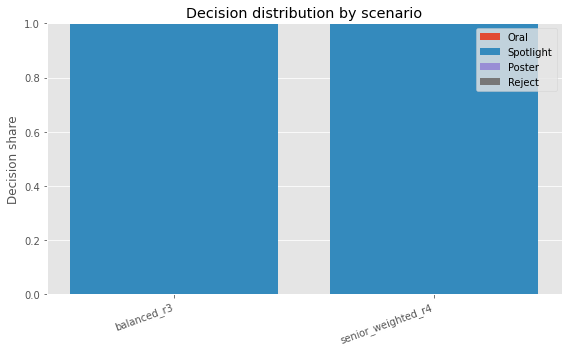

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
bottom = np.zeros(len(decision_shares))
index = np.arange(len(decision_shares))
for label in DECISION_LABELS:
    values = decision_shares[label].values if label in decision_shares else np.zeros(len(decision_shares))
    ax.bar(index, values, bottom=bottom, label=label.capitalize())
    bottom += values

ax.set_xticks(index)
ax.set_xticklabels(decision_shares.index, rotation=20, ha='right')
ax.set_ylabel('Decision share')
ax.set_ylim(0, 1)
ax.set_title('Decision distribution by scenario')
ax.legend()
plt.tight_layout()
plt.show()



In [19]:
EXPORT_PATH = Path("simulation_results.csv")  # customize as needed
simulation_df.to_csv(EXPORT_PATH, index=False)
print(f"Saved raw simulation rows to {EXPORT_PATH.resolve()}")



Saved raw simulation rows to /Users/tianyudu/Development/OB639-LLM-ABM-Simulation/simulation_results.csv


In [20]:
def show_reviews(df: pd.DataFrame, scenario_id: str, round_idx: int) -> None:
    row = df[(df['scenario_id'] == scenario_id) & (df['round'] == round_idx)]
    if row.empty:
        raise ValueError("No matching row found.")
    reviews = row.iloc[0]['reviews']
    for idx, review in enumerate(reviews, 1):
        persona = review['persona']
        print(f"Reviewer {idx} ({persona['seniority']} | {persona['expertise']}): rating={review['review']['rating']} confidence={review['review']['confidence']}")
        print("Summary:", review['review']['summary'])
        print("Strengths:", review['review']['strengths'])
        print("Weaknesses:", review['review']['weaknesses'])
        print("Questions:", review['review']['questions'])
        print("-" * 40)

# Example usage (uncomment and customize once simulation_df is populated):
# show_reviews(simulation_df, scenario_id="balanced_r3", round_idx=1)

